### Import libraries and functions

In [1]:
import sys
# adding signal_handling to the system path
sys.path.insert(0, '../signal_handling/')
sys.path.insert(0, '../nft_handling/')

import FNFTpy as fpy
import numpy as np
import timeit
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload

import signal_generation as sg
import signal_processing as sp
import ssfm
import nft_analyse as nft

reload(sp)
reload(sg)

<module 'signal_generation' from '/home/esf0/PycharmProjects/nft_processing/notebooks/../signal_handling/signal_generation.py'>

### Generate signal

In [2]:
modulation_type = "16qam"
n_car = 1
t_symb = 1.

number_of_symbols = 2 ** 14
np_symb = 16
n_lateral_symbols = 32
n_lateral = n_lateral_symbols * np_symb

z_80km_nd = sg.z_km_to_nd(80, t_symb=14.8)
p_dbm = -4  # signal average power in dBm
dt = t_symb / np_symb

In [22]:
q = sg.create_signal(number_of_symbols, p_dbm, modulation_type, n_car, t_symb=t_symb, np_symb=np_symb, n_lateral_symbols=n_lateral_symbols)
n_add = 2 ** 10 * np_symb
# n_add = 2 ** 6 * np_symb
q = sg.add_lateral(q, n_add)

# create time
n_t = len(q)
# t = np.array([(i - (n_t - 1) / 2) * dt for i in range(n_t)])
t = np.array([(i - n_t / 2) * dt for i in range(n_t)])
t_span = t[-1] - t[0]

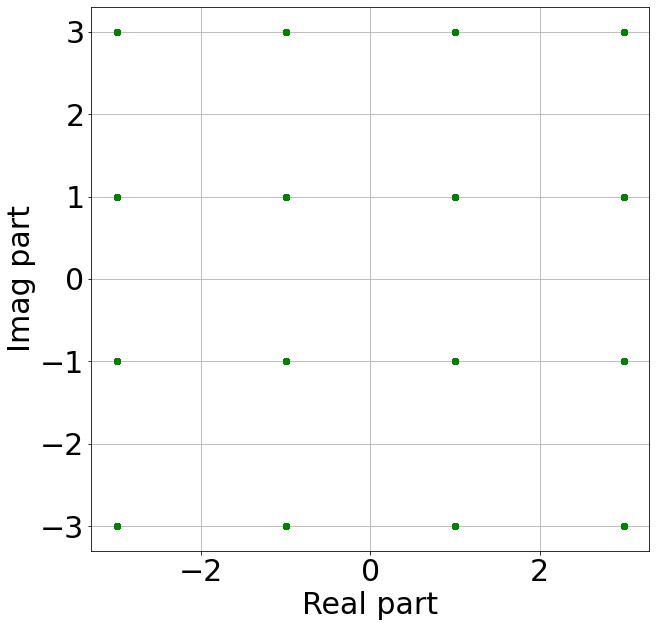

In [5]:
# points_orig = np.array(sg.get_constellation_point(data, type=modulation_type))
points_restored = np.array(sg.get_points_wdm(q, t_symb, np_symb, None, None, n_carriers=n_car, mod_type=modulation_type, n_lateral=n_lateral + n_add))
constellation_scale = sg.get_scale_coef(points_restored, modulation_type)
points_restored = constellation_scale * points_restored
# points_diff = points_orig - points_restored
# print(len(points_orig), len(points_restored))
# print(np.max(np.absolute(points_orig - points_restored)))
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(10,10))
# axs.plot(np.real(points_orig), np.imag(points_orig), color='green', marker='d', linewidth=0)
axs.plot(np.real(points_restored), np.imag(points_restored), color='green', marker='o', linewidth=0)
# axs.plot(np.real(points_diff), np.imag(points_diff), color='green', marker='o', linewidth=0)
axs.set_xlabel('Real part')
axs.set_ylabel('Imag part')
axs.grid(True)

### Calculate signal propagation

In [3]:
load_flag = True

z_80km_nd = sg.z_km_to_nd(80, t_symb=14.8)
file_name = '../data/propagated_signals/wdm_prop_m4dbm_ns14_np16_ts14p8_80x12km.npy'

# if load_flag == False then calculate propagation
if not load_flag:
    n_z_span = 12
    # ssfm propagation
    # z_prop = 100.0
    beta2 = -1.0
    gamma = 1.0

    q_prop_total = np.zeros((n_z_span + 1, len(q)), dtype=complex)  # contains all signals for n_z_span distances
    q_prop_total[0] = q
    q_prop = q


    n_z_prop = 2 ** 9
    for k_span in range(n_z_span):
        # time_start = time.time()
        q_prop = ssfm.fiber_propogate(q_prop, t_span, z_80km_nd, n_z_prop, gamma=gamma, beta2=beta2)
        q_prop_total[k_span + 1] = q_prop
        # time_end = time.time()
        # print('Time, s:', time_end - time_start)


    with open(file_name, 'wb') as f:
        np.save(f, q_prop_total)

else:
    with open(file_name, 'rb') as f:
        q_prop_total = np.load(f)
    q = q_prop_total[0]

In [4]:
n_add = 2 ** 10 * np_symb

n_t = len(q)
t = np.array([(i - n_t / 2) * dt for i in range(n_t)])
t_span = t[-1] - t[0]

In [36]:
# with open('../data/propagated_signals/wdm_prop_0dbm_ns14_np16_ts14p8_80x12km.npy', 'wb') as f:
#         np.save(f, q_prop_total)

Plot signal shape

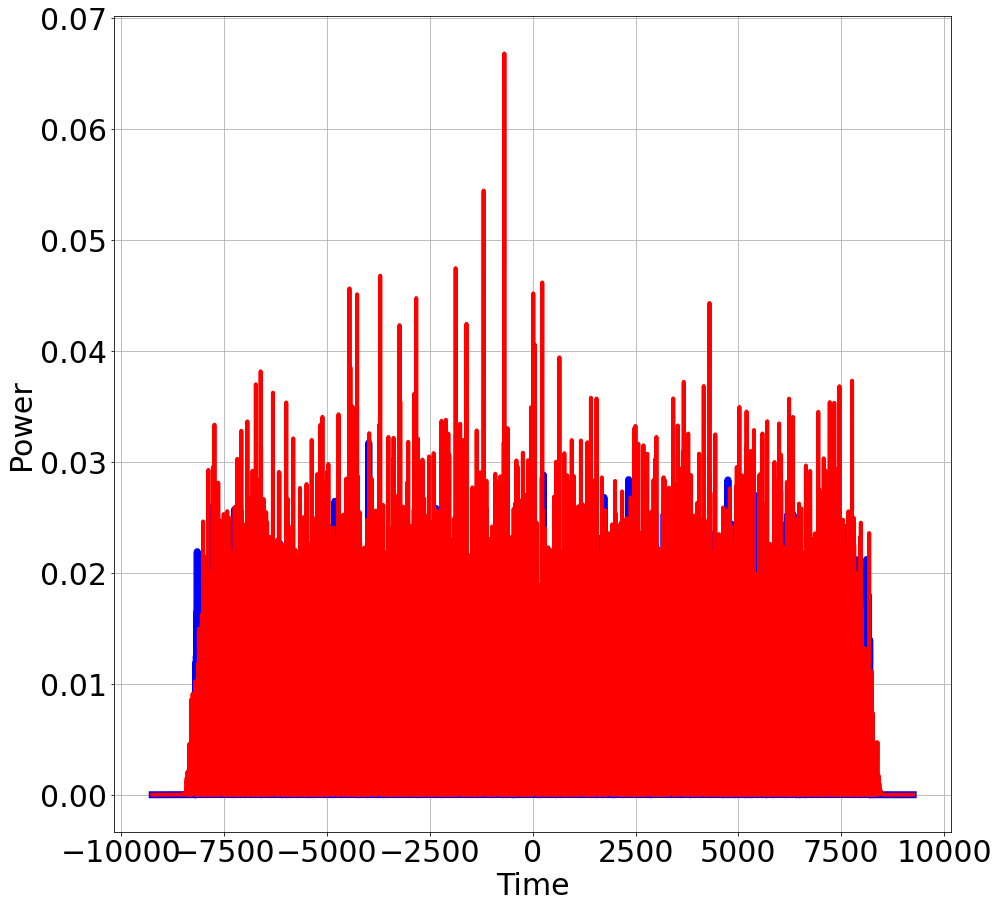

In [8]:
# choose z_prop
z_80km_nd = sg.z_km_to_nd(80, t_symb=14.8)
n_z_span_plot = 12
q_plot = q_prop_total[n_z_span_plot]

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(t, np.power(np.absolute(q), 2), 'blue', linewidth=7)
axs.plot(t, np.power(np.absolute(q_plot), 2), 'red', linewidth=4)
# axs.set_xlim(t[0], t[0] + 200)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

Process signal

In [23]:
reload(sg)
reload(sp)
reload(nft)

n_z_span_proc = 0
q_proc = q_prop_total[n_z_span_proc]
z_prop = n_z_span_proc * z_80km_nd

reload(sp)
result = sp.process_signal(q, q_proc, z_prop, np_symb, t_symb, n_car, modulation_type, constellation_scale, n_add=n_add + n_lateral, print_sys_message=True)

Time to calculate direct NFT 60.375 ms
Number of discrete eigenvalues: 0
Time to calculate continuous part of z-chirp 408.22999999999996 ms
Time to calculate TIB 510.32500000000005 ms
Time to calculate continuous part of z-chirp 453.49899999999997 ms
Time to calculate TIB 458.893 ms
[cdc] PER TIB: (0.0, 0) | BER TIB: (0.0, 0)
Time to calculate direct NFT 60.62 ms
Number of discrete eigenvalues: 0
Time to calculate continuous part of z-chirp 404.689 ms
Time to calculate TIB 457.245 ms
Time to calculate continuous part of z-chirp 402.17900000000003 ms
Time to calculate TIB 452.65 ms
[cdc] PER TIB: (0.0, 0) | BER TIB: (0.0, 0)
Time to calculate direct NFT 60.089999999999996 ms
Number of discrete eigenvalues: 0
Time to calculate continuous part of z-chirp 422.117 ms
Time to calculate TIB 453.601 ms
Time to calculate continuous part of z-chirp 405.44599999999997 ms
Time to calculate TIB 451.132 ms
[cdc] PER TIB: (0.0, 0) | BER TIB: (0.0, 0)
Time to calculate direct NFT 58.346000000000004 ms

In [16]:
print(np.shape(q_prop_total))

(3, 265216)


In [163]:
n_z_span_proc = 2
q_proc = q_prop_total[n_z_span_proc]
z_prop = n_z_span_proc * z_80km_nd

window_mode = 'cdc'
xi_upsampling = 4

ns_proc = 8
ns_d = 130 - ns_proc // 2
ns_total = ns_proc + 2 * ns_d
ns_skip = 256  # initial number of symbols to skip to eliminate border effects
t_n_add = n_add + n_lateral

step = ns_proc  # step size in number of symbols for signal processing. Each iteration window shifts to step
n_steps = 1  # total number of steps (iterations)

# lists of all points found
# for NFT
points = []
points_scaled = []
points_found = []
# original points
points_original = []
points_original_scaled = []
points_original_found = []

for proc_iter in range(n_steps):

    np_skip = ns_skip * np_symb + t_n_add

    q_nft, t_nft, result_dbp_nft, n_add_nft = sp.process_nft_window(q_proc, z_prop, np_symb, t_symb, ns_proc, ns_d, ns_skip, t_n_add,
                                               window_mode=window_mode, xi_upsampling=xi_upsampling)
    t_points = sp.get_points_from_signal(q_nft, np_symb, t_symb, n_car, modulation_type,
                                         constellation_scale, n_add=n_add_nft)


    q_cut, t_cut = sp.get_sub_signal(q, np_symb, t_symb, ns_total, ns_skip, t_n_add)
    q_cut_t, t_cut_t = sp.add_lateral_to_signal(q_cut, sp.slope_zero, t_cut, n_add_nft)
    t_points_original = sp.get_points_from_signal(q_cut, np_symb, t_symb, n_car, modulation_type, constellation_scale)

    points = np.concatenate((points, sp.get_points_range(t_points[0], ns_proc, ns_d)))
    points_scaled = np.concatenate((points_scaled, sp.get_points_range(t_points[1], ns_proc, ns_d)))
    points_found = np.concatenate((points_found, sp.get_points_range(t_points[2], ns_proc, ns_d)))

    points_original = np.concatenate((points_original, sp.get_points_range(t_points_original[0], ns_proc, ns_d)))
    points_original_scaled = np.concatenate((points_original_scaled, sp.get_points_range(t_points_original[1], ns_proc, ns_d)))
    points_original_found = np.concatenate((points_original_found, sp.get_points_range(t_points_original[2], ns_proc, ns_d)))

    ns_skip += step

Number of discrete eigenvalues: 27


In [68]:
# q_cut, t_cut = sp.get_sub_signal(q, np_symb, t_symb, ns_proc + 2 * ns_d, 20, t_n_add)

In [161]:
# points = []
print(np.shape(t_points[0]))
print(sp.get_points_range(t_points[0], ns_proc, ns_d))
print(np.concatenate((points, sp.get_points_range(t_points[0], ns_proc, ns_d))))
print(np.shape(points))
print(points)

(260,)
[-0.05276002+0.01111746j  0.03800764-0.01228096j  0.07590879+0.03517368j
  0.02018472-0.01742925j  0.06326553+0.03101815j  0.06078391+0.08295657j
  0.00791116-0.06554288j  0.0104133 -0.08156932j]
[-0.05276002+0.01111746j  0.03800764-0.01228096j  0.07590879+0.03517368j
  0.02018472-0.01742925j  0.06326553+0.03101815j  0.06078391+0.08295657j
  0.00791116-0.06554288j  0.0104133 -0.08156932j -0.05276002+0.01111746j
  0.03800764-0.01228096j  0.07590879+0.03517368j  0.02018472-0.01742925j
  0.06326553+0.03101815j  0.06078391+0.08295657j  0.00791116-0.06554288j
  0.0104133 -0.08156932j]
(8,)
[-0.05276002+0.01111746j  0.03800764-0.01228096j  0.07590879+0.03517368j
  0.02018472-0.01742925j  0.06326553+0.03101815j  0.06078391+0.08295657j
  0.00791116-0.06554288j  0.0104133 -0.08156932j]


In [89]:
print(np.shape(q_cut))

(2048,)


/tmp/ipykernel_12085/808623111.py:26: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].plot(t_nft, np.absolute(q_nft - q_cut_t) / np.absolute(q_cut_t), 'blue', linewidth=7)


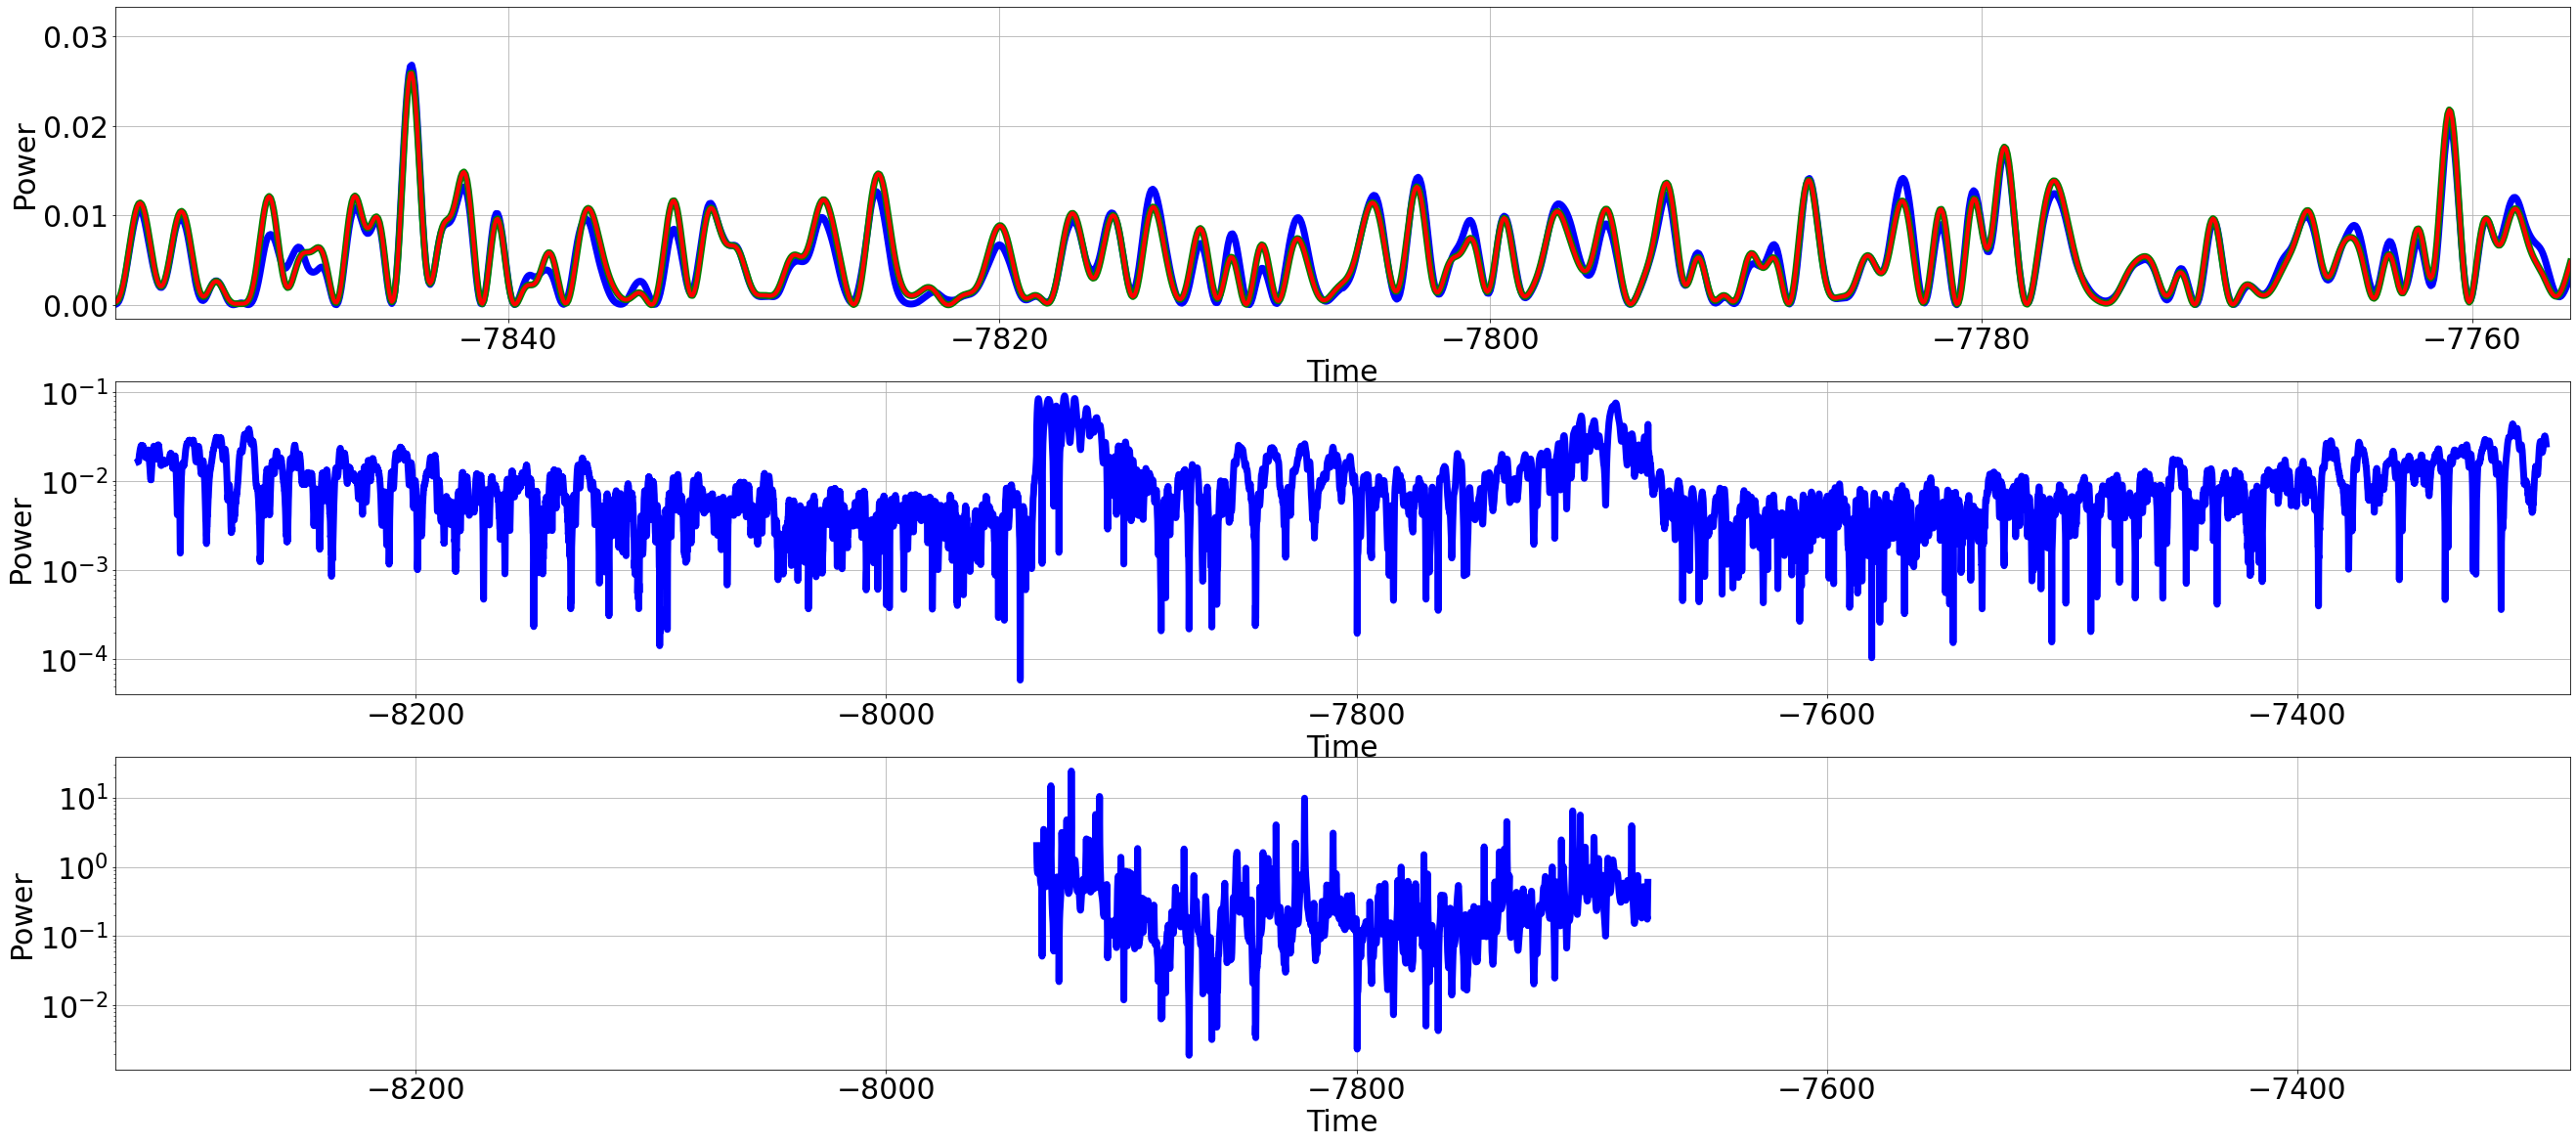

In [148]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(3, 1, figsize=(45,20))
axs[0].plot(t_nft, np.power(np.absolute(q_nft), 2), 'blue', linewidth=7)
axs[0].plot(t_cut, np.power(np.absolute(q_cut), 2), 'green', linewidth=7)
axs[0].plot(t, np.power(np.absolute(q), 2), 'red', linewidth=4)
# axs.set_xlim(t[0]+200, t[0] + 300)
# axs.set_xlim(t_nft[0] - 100, t_nft[-1] + 100)
sh = 50
axs[0].set_xlim(t_nft[0] - 10, t_nft[-1] + 10)
axs[0].set_xlim((t_nft[0] + t_nft[-1]) / 2 - sh, (t_nft[0] + t_nft[-1]) / 2 + sh)
# axs[0].set_xlim(t_nft[0] + 50, t_nft[-1] - 50)
# axs.set_xlim(t_nft[0] - 10, t_nft[0] + 10)
# axs.set_xlim(t_nft[0] + 10, t_nft[0] + 100)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(t_nft, np.absolute(q_nft - q_cut_t), 'blue', linewidth=7)
axs[1].set_xlim(t_nft[0] - 10, t_nft[-1] + 10)
axs[1].set_yscale('log')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Power')
axs[1].grid(True)

axs[2].plot(t_nft, np.absolute(q_nft - q_cut_t) / np.absolute(q_cut_t), 'blue', linewidth=7)
axs[2].set_xlim(t_nft[0] - 10, t_nft[-1] + 10)
axs[2].set_yscale('log')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Power')
axs[2].grid(True)

In [ ]:
# axs.set_xlim(t_nft[0] - 100, t_nft[-1] + 100)

In [151]:
print(np.shape(points))

(48,)


1600
(0.00140625, 9)


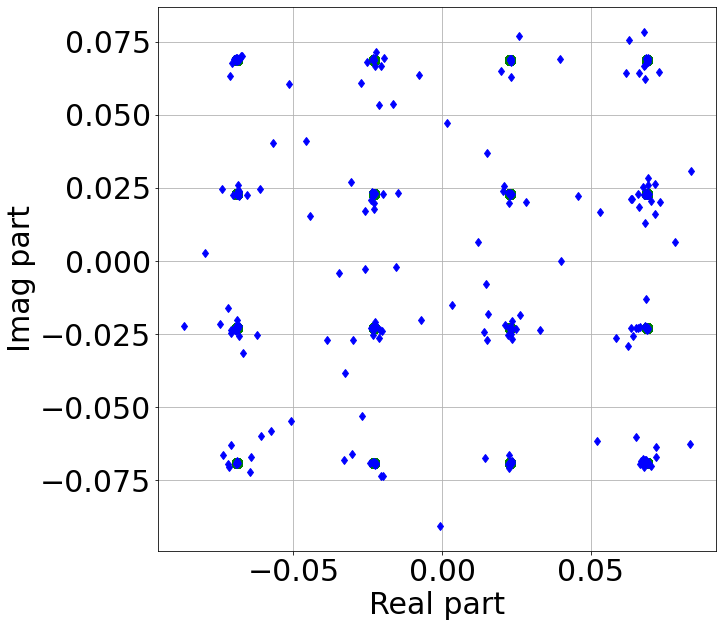

In [24]:
points = result['points']
points_original = result['points_original']

points_found = result['points_found']
points_original_found = result['points_original_found']

print(len(points_found))
print(sg.get_ber_by_points(points_original_found, points_found, modulation_type))

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.plot(np.real(points_original), np.imag(points_original), color='green', marker='o', linewidth=0, markersize=10)
axs.plot(np.real(points), np.imag(points), color='blue', marker='d', linewidth=0)
# # axs.plot(np.real(points_diff), np.imag(points_diff), color='green', marker='o', linewidth=0)

# axs.plot(np.real(points_found), np.imag(points_found), color='blue', marker='d', linewidth=0)
# axs.plot(np.real(points_original_found), np.imag(points_original_found), color='green', marker='o', linewidth=0)
axs.set_xlabel('Real part')
axs.set_ylabel('Imag part')
axs.grid(True)

In [99]:
result_dbp_nft = nft.make_dbp_nft(q_prop, t - (t[-1] + t[0]) / 2, z_80km_nd,
                                  xi_upsampling=16, inverse_type='tib',
                                  fnft_type=0,
                                  print_sys_message=True)

q_nft = result_dbp_nft['q_total']

Number of discrete eigenvalues: 28


mean error: 0.01187421752909119
max error: 0.024033443240828244


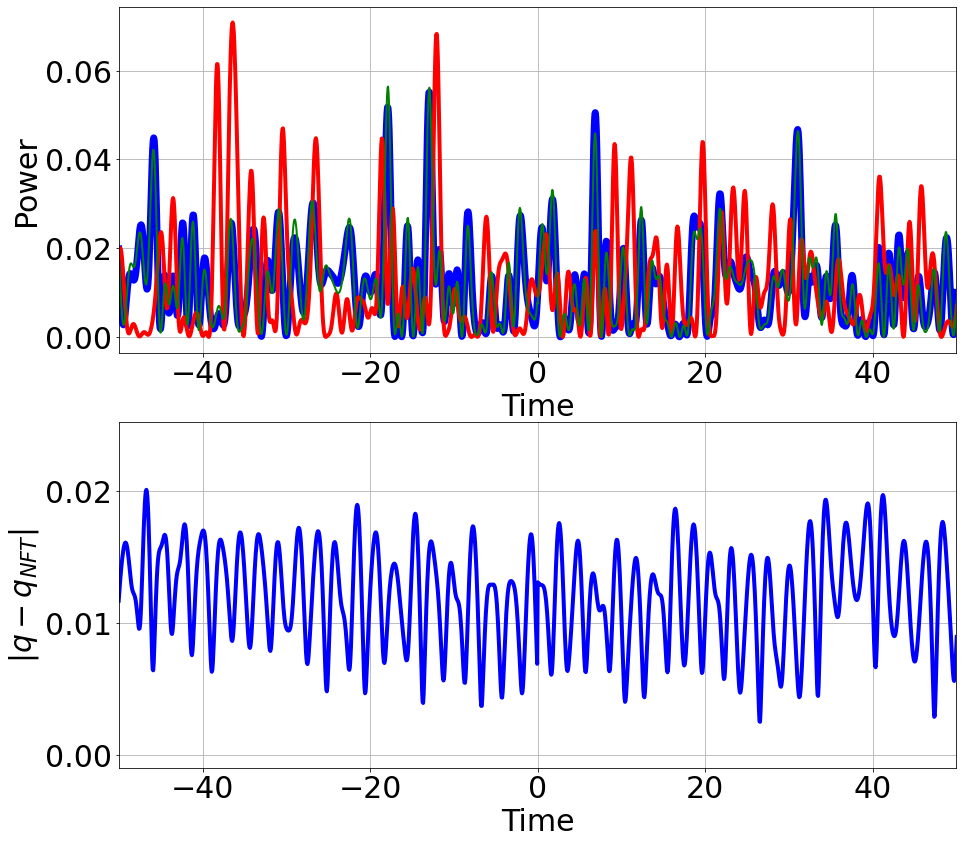

In [100]:
fig, axs = plt.subplots(2, 1, figsize=(15,14))
axs[0].plot(t, np.power(np.absolute(q), 2), 'blue', linewidth=7)
axs[0].plot(t, np.power(np.absolute(q_prop), 2), 'red', linewidth=4)
axs[0].plot(t, np.power(np.absolute(q_nft), 2), 'green', linewidth=2)
axs[0].set_xlim(-50, 50)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)


axs[1].plot(t, np.absolute(q - q_nft), 'blue', linewidth=4)
axs[1].set_xlim(-50, 50)
axs[1].set_xlabel('Time')
axs[1].set_ylabel(r'$|q - q_{NFT}|$')
axs[1].grid(True)

print("mean error:", np.mean(np.absolute(q - q_nft)))
print("max error:", np.max(np.absolute(q - q_nft)))